In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:
teams = pd.read_csv('nfl_teams.csv')
games = pd.read_csv('games.csv')

# Dimensions of games
print(games.shape)
print(teams.shape)

(14086, 17)
(44, 8)


In [ ]:
# Can we predict a high-scoring game? Will we be able to tell if a game will be in the top 25% of games by total points?
# Can we predict the winner of a game?
# Can we predict if the favorite covers the spread?C

In [4]:
# Feature Engineering

# Convert schedule date column to datetime format for time-based analysis
games["schedule_date"] = pd.to_datetime(games["schedule_date"], errors='coerce')
games["schedule_date"].head()

# Create a column for decade
games["decade"] = (games["schedule_season"] // 10) * 10
games["decade"].head()

# Convert over/under betting line to numeric format (float)
games["over_under_line"] = pd.to_numeric(games["over_under_line"], errors='coerce')
games["over_under_line"].head()

# Create total points scored in each game
games["total_points"] = games["score_home"] + games["score_away"]
games["total_points"].head()

# Create point differential (home team score minus away team score)
games["points_diff"] = games["score_home"] - games["score_away"]
games["points_diff"].head()

# Map 3-letter team codes to full team names using the teams dataset
team_id_map = teams.set_index("team_id")["team_name"].to_dict()
games["team_favorite_name"] = games["team_favorite_id"].map(team_id_map)
games["team_favorite_name"].tail()

# Identify the score of the favorite team
games["favorite_score"] = np.where(games["team_favorite_name"] == games["team_home"], games["score_home"], games["score_away"])

# Identify the score of the underdog team
games["underdog_score"] = np.where(games["team_favorite_name"] == games["team_home"], games["score_away"], games["score_home"])

# Calculate the favorite's margin of victory
games["favorite_margin"] = games["favorite_score"] - games["underdog_score"]

# Determine if the favorite covered the spread
games["favorite_covered"] = np.where(games["favorite_margin"] > games["spread_favorite"], 1, 0)


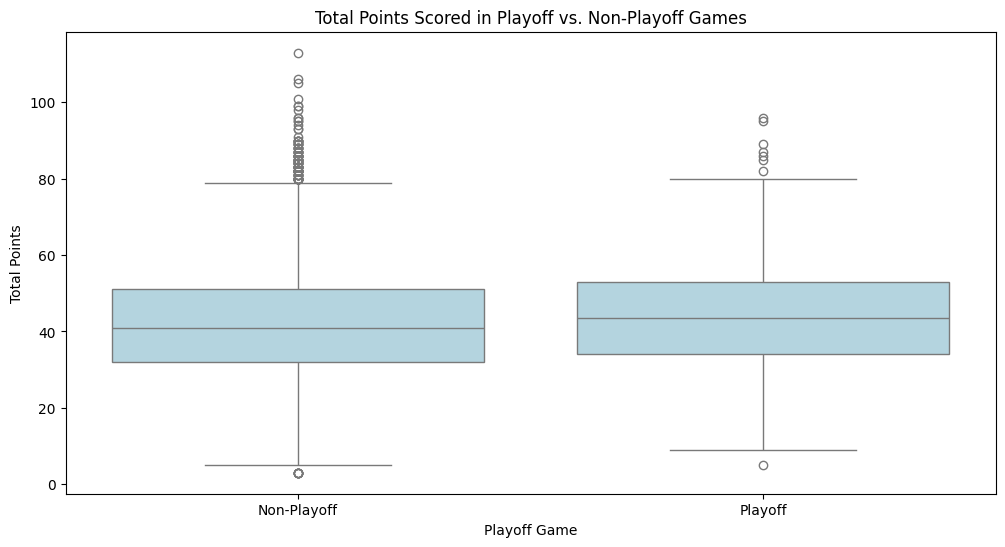

In [5]:
# EDA

# Boxplot of total points scored in and out of playoff games
plt.figure(figsize=(12, 6))
sns.boxplot(x="schedule_playoff", y="total_points", data=games, color="lightblue")
plt.title("Total Points Scored in Playoff vs. Non-Playoff Games")
plt.xlabel("Playoff Game")
plt.ylabel("Total Points")
plt.xticks([0, 1], ["Non-Playoff", "Playoff"])
plt.show()

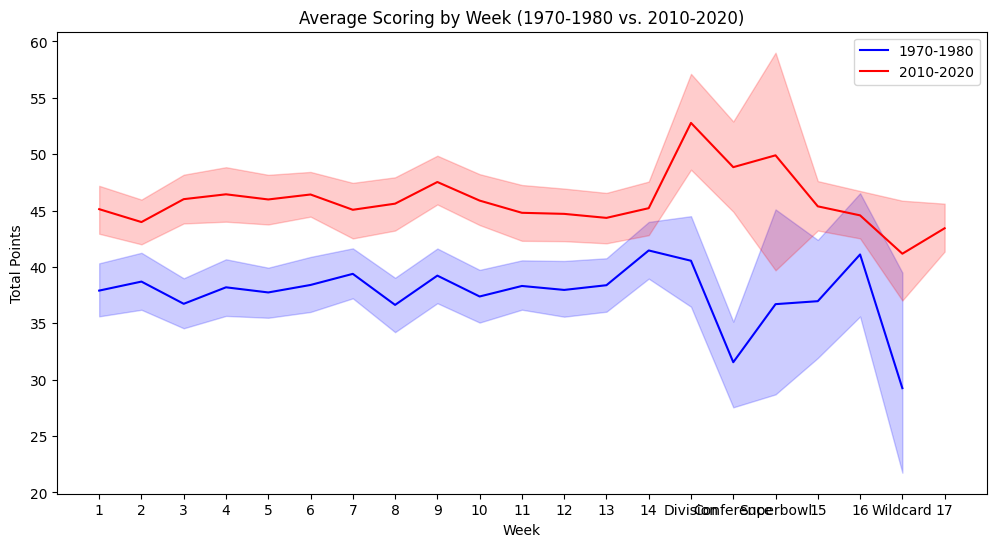

In [6]:
# Aberage Scoring by Week from 1970 to 1980 vs. 2010 to 2020 in Weeks 1-16
plt.figure(figsize=(12, 6))
sns.lineplot(data=games[(games["schedule_season"] >= 1970) & (games["schedule_season"] < 1980)], 
             x="schedule_week", y="total_points", label="1970-1980", color="blue")
sns.lineplot(data=games[(games["schedule_season"] >= 2010) & (games["schedule_season"] < 2020)],
              x="schedule_week", y="total_points", label="2010-2020", color="red")
plt.title("Average Scoring by Week (1970-1980 vs. 2010-2020)")
plt.xlabel("Week")
plt.ylabel("Total Points")
plt.legend()
plt.show()


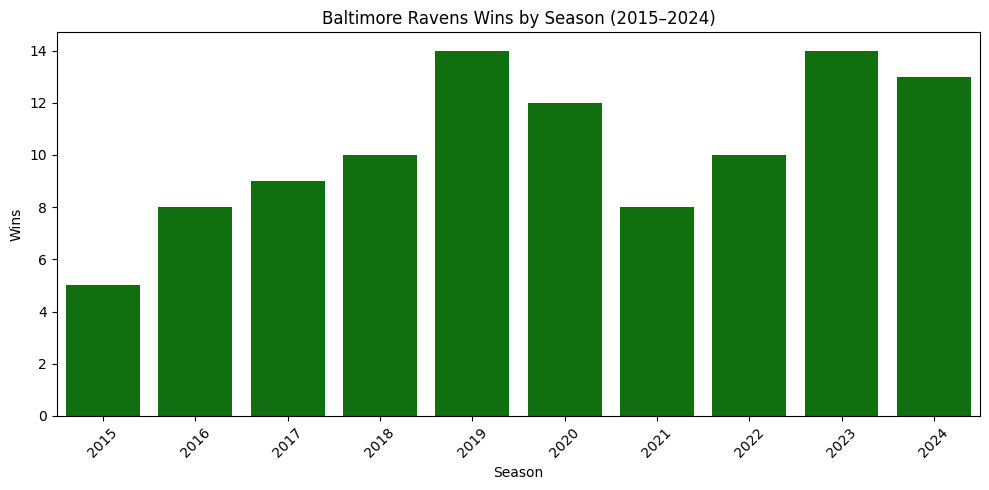

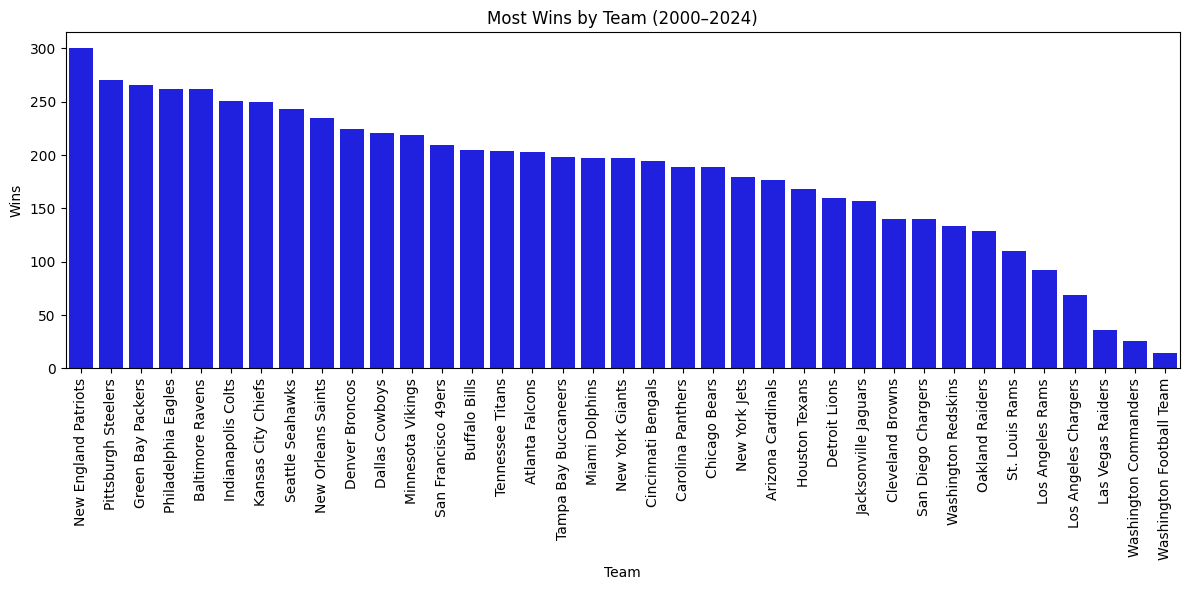

In [15]:
def plot_team_wins(start_year, end_year, team=None):

    filtered = games[(games["schedule_season"] >= start_year) & (games["schedule_season"] <= end_year)].copy()
    filtered["team_winner"] = np.where(
        filtered["score_home"] > filtered["score_away"],
        filtered["team_home"],
        np.where(filtered["score_home"] < filtered["score_away"], filtered["team_away"], "TIE")
    )
    filtered = filtered[filtered["team_winner"] != "TIE"]

    if team:
        win_counts = filtered[filtered["team_winner"] == team]["schedule_season"].value_counts().sort_index()
        plt.figure(figsize=(10, 5))
        sns.barplot(x=win_counts.index.astype(str), y=win_counts.values, color="green")
        plt.title(f"{team} Wins by Season ({start_year}–{end_year})")
        plt.xlabel("Season")
        plt.ylabel("Wins")
        plt.xticks(rotation=45)
    else:
        win_counts = filtered["team_winner"].value_counts().sort_values(ascending=False)
        plt.figure(figsize=(12, 6))
        sns.barplot(x=win_counts.index, y=win_counts.values, color="blue")
        plt.title(f"Most Wins by Team ({start_year}–{end_year})")
        plt.xlabel("Team")
        plt.ylabel("Wins")
        plt.xticks(rotation=90)

    plt.tight_layout()
    plt.show()
plot_team_wins(2015, 2024, team="Baltimore Ravens")
plot_team_wins(2000, 2024)

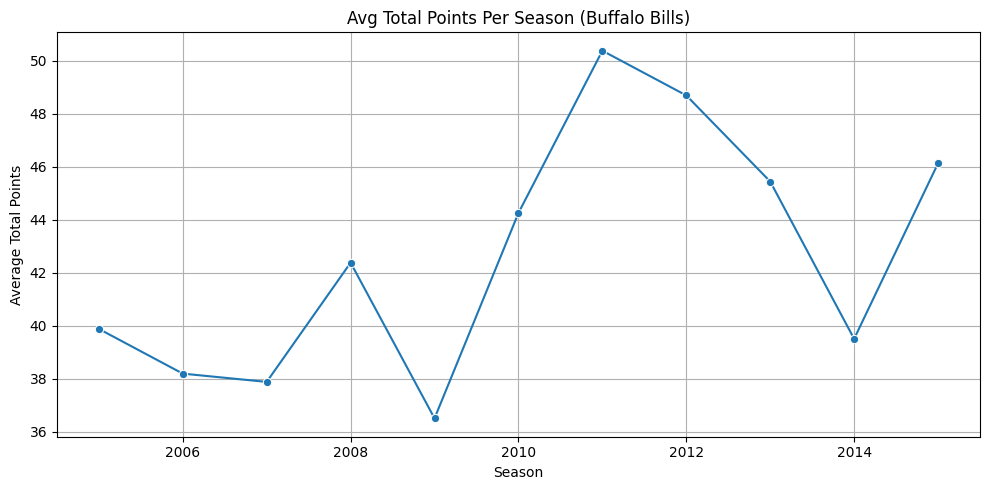

In [16]:
def plot_scoring_trend(start_year, end_year, team=None):
    filtered = games[(games["schedule_season"] >= start_year) & (games["schedule_season"] <= end_year)].copy()

    if team:
        filtered = filtered[(filtered["team_home"] == team) | (filtered["team_away"] == team)]
    
    filtered["total_points"] = filtered["score_home"] + filtered["score_away"]
    
    avg_points = filtered.groupby("schedule_season")["total_points"].mean()

    # Plot
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=avg_points.index, y=avg_points.values, marker="o")
    title = f"Avg Total Points Per Season ({team})" if team else "Avg Total Points Per Season (All Teams)"
    plt.title(title)
    plt.xlabel("Season")
    plt.ylabel("Average Total Points")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_scoring_trend(2005, 2015, team="Buffalo Bills")

/var/folders/0x/hkrqwf3s1jj9l0jvj51422xr0000gn/T/ipykernel_95171/819653318.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_spread.index, y=avg_spread.values, palette="coolwarm")


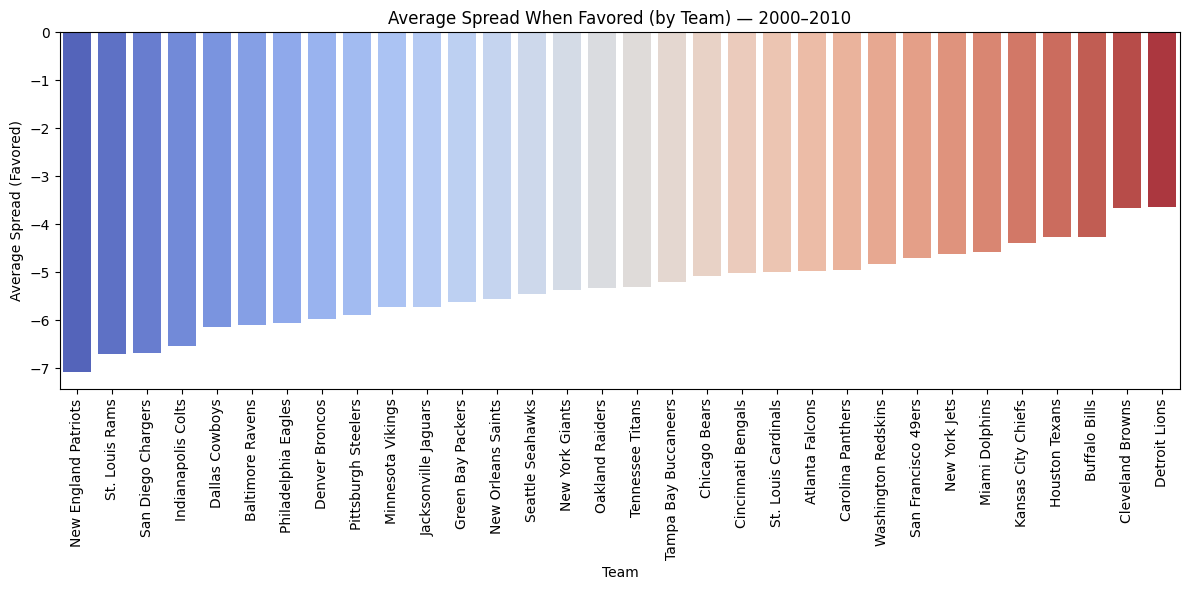

In [17]:
def plot_avg_spread_by_team(start_year, end_year):

    team_id_map = teams.set_index("team_id")["team_name"].to_dict()
    
    filtered = games[
        (games["schedule_season"] >= start_year) &
        (games["schedule_season"] <= end_year)
    ].copy()
    filtered["team_favorite_name"] = filtered["team_favorite_id"].map(team_id_map)
    filtered = filtered.dropna(subset=["spread_favorite", "team_favorite_name"])

    avg_spread = filtered.groupby("team_favorite_name")["spread_favorite"].mean().sort_values()

    plt.figure(figsize=(12, 6))
    sns.barplot(x=avg_spread.index, y=avg_spread.values, palette="coolwarm")
    plt.title(f"Average Spread When Favored (by Team) — {start_year}–{end_year}")
    plt.xlabel("Team")
    plt.ylabel("Average Spread (Favored)")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_avg_spread_by_team(2000, 2010)

In [5]:
threshold = games['total_points'].quantile(0.75)
games['high_scoring'] = np.where(games['total_points'] >= threshold, 1, 0)

In [6]:
games['is_indoor'] = games['weather_detail'] == 'indoor'
games['weather_temperature'] = pd.to_numeric(games['weather_temperature'], errors='coerce')

In [7]:
# Filter out special games and stadiums
stadium_counts = games['stadium'].value_counts()
valid_stadiums = stadium_counts[stadium_counts >= 15].index
games = games[games['stadium'].isin(valid_stadiums)]

In [8]:
games['schedule_playoff'] = games['schedule_playoff'].astype(bool)
games['weather_temperature'] = pd.to_numeric(games['weather_temperature'], errors='coerce')
games['weather_wind_mph'] = pd.to_numeric(games['weather_wind_mph'], errors='coerce')
games['weather_humidity'] = pd.to_numeric(games['weather_humidity'], errors='coerce')
games = games[games['schedule_week'].apply(lambda x: str(x).isdigit())]
games['schedule_week'] = games['schedule_week'].astype(int)

In [9]:
# Feature Selection
model_data = games[[
    'high_scoring', 'spread_favorite', 'weather_temperature', 'weather_wind_mph',
    'weather_humidity', 'schedule_week', 'stadium', 'team_home', 'team_away', 'schedule_playoff'
]].dropna()
X = model_data.drop(columns='high_scoring')
y = model_data['high_scoring']


In [10]:
# Column classification
numeric_features = ['spread_favorite', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'schedule_week']
categorical_features = ['stadium', 'team_home', 'team_away', 'schedule_playoff']

In [11]:
# Preprocessing
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
    remainder='drop'
)

In [12]:
# pipeline
pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear'))


In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [14]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['spread_favorite',
                                                   'weather_temperature',
                                                   'weather_wind_mph',
                                                   'weather_humidity',
                                                   'schedule_week']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['stadium', 'team_home',
                                                   'team_away',
                                                   'schedule_playoff'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

In [15]:
# Results
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5663224781572677

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.59      0.67       933
           1       0.30      0.50      0.37       326

    accuracy                           0.57      1259
   macro avg       0.53      0.54      0.52      1259
weighted avg       0.65      0.57      0.59      1259


Confusion Matrix:
 [[550 383]
 [163 163]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [104]:
games = games.copy()
games['home_team_won'] = (games['score_home'] > games['score_away']).astype(int)

In [105]:
games = games[games['schedule_week'].apply(lambda x: str(x).isdigit())]
games['schedule_week'] = games['schedule_week'].astype(int)

model2 = games[['home_team_won', 'spread_favorite', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'schedule_week',
                  'stadium', 'team_home', 'team_away', 'schedule_playoff'
]].dropna()

In [106]:
numeric_cols2 = ['spread_favorite', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'schedule_week']
categorical_cols2 = ['stadium', 'team_home', 'team_away', 'schedule_playoff']

In [107]:
preprocessor2 = ColumnTransformer(transformers=[
    ('num', 'passthrough', numeric_cols2),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols2)
])

In [108]:
pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [109]:
x2 = model2.drop(columns='home_team_won')
y2 = model2['home_team_won']

x_train2, x_test2, y_train2, y_test2 = train_test_split(
    x2, y2, test_size=0.2, random_state=42, stratify=y2
)

pipeline2.fit(x_train2, y_train2)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['spread_favorite',
                                                   'weather_temperature',
                                                   'weather_wind_mph',
                                                   'weather_humidity',
                                                   'schedule_week']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['stadium', 'team_home',
                                                   'team_away',
                                                   'schedule_playoff'])])),
                ('model', RandomForestClassifier(random_state=42))])

In [110]:
y_pred2 = pipeline2.predict(x_test2)

print("Accuracy:", accuracy_score(y_test2, y_pred2))
print("\nClassification Report:\n", classification_report(y_test2, y_pred2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test2, y_pred2))


Accuracy: 0.5758538522637013

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.31      0.38       521
           1       0.61      0.76      0.68       738

    accuracy                           0.58      1259
   macro avg       0.55      0.54      0.53      1259
weighted avg       0.56      0.58      0.55      1259


Confusion Matrix:
 [[163 358]
 [176 562]]


In [112]:
model3 = games[['favorite_covered', 'home_team_won', 'spread_favorite', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'schedule_week',
                  'stadium', 'team_home', 'team_away', 'schedule_playoff']].dropna()

In [113]:
numeric_cols3 = ['spread_favorite', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'schedule_week']
categorical_cols3 = ['stadium', 'team_home', 'team_away', 'schedule_playoff']

In [114]:
preprocessor3 = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols3),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols3)
    ]
)

In [115]:
pipeline3 = Pipeline(steps=[
    ('preprocessor', preprocessor3),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [ ]:
x3 = model3.drop(columns='favorite_covered')
y3 = model3['favorite_covered']

In [117]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(
    x3, y3, test_size=0.2, random_state=42, stratify=y3
)
pipeline3.fit(x_train3, y_train3)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:52:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['spread_favorite',
                                                   'weather_temperature',
                                                   'weather_wind_mph',
                                                   'weather_humidity',
                                                   'schedule_week']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['stadium', 'team_home',
                                                   'team_away',
                                                   'schedule_playoff'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=Non...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [118]:
y_pred3 = pipeline3.predict(x_test3)

print("Accuracy:", accuracy_score(y_test3, y_pred3))
print("\nClassification Report:\n", classification_report(y_test3, y_pred3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test3, y_pred3))

Accuracy: 0.7259729944400317

Classification Report:
               precision    recall  f1-score   support

           0       0.41      0.21      0.28       316
           1       0.77      0.90      0.83       943

    accuracy                           0.73      1259
   macro avg       0.59      0.56      0.56      1259
weighted avg       0.68      0.73      0.69      1259


Confusion Matrix:
 [[ 67 249]
 [ 96 847]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Optimize the model
# Choosing model 3 as this is the most likely to be used in a betting context and is the most accurate among the three, 
# therefore showing the most potential for optimization.

In [ ]:
# Long format transformation to compute win streaks
home_games = games[["schedule_date", "team_home", "score_home", "score_away"]].copy()
home_games.columns = ["schedule_date", "team", "points_scored", "points_allowed"]
home_games["won"] = (home_games["points_scored"] > home_games["points_allowed"]).astype(int)

away_games = games[["schedule_date", "team_away", "score_away", "score_home"]].copy()
away_games.columns = ["schedule_date", "team", "points_scored", "points_allowed"]
away_games["won"] = (away_games["points_scored"] > away_games["points_allowed"]).astype(int)

# Calculate rolling 3-game win streaks
long_games = pd.concat([home_games, away_games])
long_games = long_games.sort_values(["team", "schedule_date"])
long_games["recent_3_wins"] = (
    long_games.groupby("team")["won"]
    .transform(lambda x: x.shift().rolling(window=3, min_periods=1).sum())
)

In [17]:
# Home and away team recent win streaks
home_streaks = long_games[["schedule_date", "team", "recent_3_wins"]].rename(
    columns={"team": "team_home", "recent_3_wins": "home_team_recent_wins"}
)
away_streaks = long_games[["schedule_date", "team", "recent_3_wins"]].rename(
    columns={"team": "team_away", "recent_3_wins": "away_team_recent_wins"}
)

games = pd.merge(games, home_streaks, on=["schedule_date", "team_home"], how="left")
games = pd.merge(games, away_streaks, on=["schedule_date", "team_away"], how="left")

In [18]:
# Is favorite team the home team
games["is_favorite_home"] = (games["team_favorite_name"] == games["team_home"]).astype(int)

# Create underdog team name
games["team_underdog_name"] = np.where(
    games["team_favorite_name"] == games["team_home"],
    games["team_away"],
    games["team_home"]
)

# Favorite and underdog recent win streaks
favorite_streaks = long_games.rename(columns={"team": "team_favorite_name", "recent_3_wins": "favorite_recent_wins"})
underdog_streaks = long_games.rename(columns={"team": "team_underdog_name", "recent_3_wins": "underdog_recent_wins"})

games = pd.merge(games, favorite_streaks[["schedule_date", "team_favorite_name", "favorite_recent_wins"]],
                 on=["schedule_date", "team_favorite_name"], how="left")

games = pd.merge(games, underdog_streaks[["schedule_date", "team_underdog_name", "underdog_recent_wins"]],
                 on=["schedule_date", "team_underdog_name"], how="left")

In [20]:
model4 = games[[
    'favorite_covered',
    'spread_favorite', 'weather_temperature', 'weather_wind_mph', 'weather_humidity',
    'schedule_week', 'stadium', 'team_home', 'team_away', 'schedule_playoff',
    'home_team_recent_wins', 'away_team_recent_wins',
    'favorite_recent_wins', 'underdog_recent_wins', 'is_favorite_home'
]].dropna()

# Define features and target
x4 = model4.drop(columns='favorite_covered')
y4 = model4['favorite_covered']

In [21]:
numeric_cols4 = [
    'spread_favorite', 'weather_temperature', 'weather_wind_mph', 'weather_humidity',
    'schedule_week', 'home_team_recent_wins', 'away_team_recent_wins',
    'favorite_recent_wins', 'underdog_recent_wins', 'is_favorite_home'
]

categorical_cols4 = ['stadium', 'team_home', 'team_away', 'schedule_playoff']

In [22]:
preprocessor4 = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols4),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols4)
    ]
)

In [23]:
pipeline4 = Pipeline(steps=[
    ('preprocessor', preprocessor4),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

In [24]:
x_train4, x_test4, y_train4, y_test4 = train_test_split(
    x4, y4, test_size=0.2, stratify=y4, random_state=42
)

In [25]:
pipeline4.fit(x_train4, y_train4)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:55:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['spread_favorite',
                                                   'weather_temperature',
                                                   'weather_wind_mph',
                                                   'weather_humidity',
                                                   'schedule_week',
                                                   'home_team_recent_wins',
                                                   'away_team_recent_wins',
                                                   'favorite_recent_wins',
                                                   'underdog_recent_wins',
                                                   'is_favorite_home']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignor...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [26]:
y_pred4 = pipeline4.predict(x_test4)

# Evaluation
print("Accuracy:", accuracy_score(y_test4, y_pred4))
print("\nClassification Report:\n", classification_report(y_test4, y_pred4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test4, y_pred4))

Accuracy: 0.7348160821214713

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.19      0.25       277
           1       0.78      0.90      0.84       892

    accuracy                           0.73      1169
   macro avg       0.58      0.55      0.55      1169
weighted avg       0.69      0.73      0.70      1169


Confusion Matrix:
 [[ 52 225]
 [ 85 807]]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
